Retrieved message [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 

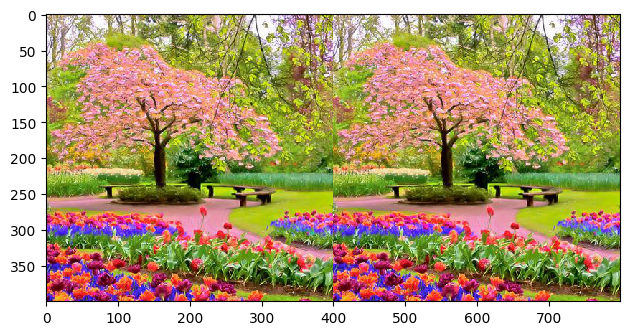

In [2]:
import numpy as np
import random
from PIL import Image
from skimage import io
from skimage.util import view_as_blocks
from scipy.fftpack import dct, idct
# from studfile_dct import dct, idct

u1, v1 = 4, 5
u2, v2 = 5, 4
n = 8
P = 25
layer_to_modify = 2
print_matrix = True

def double_to_byte(arr):
    return np.uint8(np.round(np.clip(arr, 0, 255), 0))

def increment_abs(x):
    return x + 1 if x >= 0 else x - 1

def decrement_abs(x):
    if np.abs(x) <= 1:
        return 0
    else:
        return x - 1 if x >= 0 else x + 1

def abs_diff_coefs(transform):
    return abs(transform[u1, v1]) - abs(transform[u2, v2])

def valid_coefficients(transform, bit, threshold):
    difference = abs_diff_coefs(transform)
    if (bit == 0) and (difference > threshold):
        return True
    elif (bit == 1) and (difference < -threshold):
        return True
    else:
        return False

def change_coefficients(transform, bit):
    coefs = transform.copy()
    if bit == 0:
        coefs[u1, v1] = increment_abs(coefs[u1, v1])
        coefs[u2, v2] = decrement_abs(coefs[u2, v2])
    elif bit == 1:
        coefs[u1, v1] = decrement_abs(coefs[u1, v1])
        coefs[u2, v2] = increment_abs(coefs[u2, v2])
    return coefs

def embed_bit(block, bit):
    patch = block.copy()
    coefs = dct(dct(patch, axis=0), axis=1)
    while not valid_coefficients(coefs, bit, P) or (bit != retrieve_bit(patch)):
        coefs = change_coefficients(coefs, bit)
        patch = double_to_byte(idct(idct(coefs, axis=0), axis=1)/(2*n)**2)
    global print_matrix
    # if layer_to_modify == 2 and print_matrix:
    #     print_markdown_table(coefs)
    #     for arr in coefs:
    #         print([f'{i:.2f}' for i in arr])
    #     print_matrix = False
    return patch

def embed_message(orig, msg):
    changed = orig.copy()
    blue = changed[:, :, layer_to_modify]
    # example = Image.new('RGB', (n * 2, n))
    # colored = Image.fromarray(changed[:n, :n])
    # blue_block = Image.fromarray(blue[:n, :n])
    # example.paste(colored, (0, 0))
    # example.paste(blue_block, (n, 0))
    # example.save('block.png')
    blocks = view_as_blocks(blue, block_shape=(n, n))
    h = blocks.shape[1]        
    for index, bit in enumerate(msg):
        i = index // h
        j = index % h
        block = blocks[i, j]
        blue[i*n: (i+1)*n, j*n: (j+1)*n] = embed_bit(block, bit) # embedding The Bit into all pixels of current block
    changed[:, :, 2] = blue
    return changed

def retrieve_bit(block):
    transform = dct(dct(block, axis=0), axis=1)
    return 0 if abs_diff_coefs(transform) > 0 else 1

def retrieve_message(img, length):
    blocks = view_as_blocks(img[:, :, layer_to_modify], block_shape=(n, n))
    h = blocks.shape[1]
    return [retrieve_bit(blocks[index//h, index%h]) for index in range(length)]


original = io.imread('./TUV0V.png')
test_message = [random.randint(0, 1) for i in range(int(400 * 400 / n / n))]
images = [original]

for i in range(2, 3):
    layer_to_modify = i
    changed = embed_message(original, test_message)
    retrieved_message = retrieve_message(changed, len(test_message))
    print('Retrieved message', retrieved_message)
    print('Messages are equal:', test_message == retrieved_message)
    images.append(changed)

io.imshow(np.hstack(images))
io.imsave('from.png', original)
io.imsave('to.png', changed)

In [ ]:
from PIL import Image
import os

def combine_images(folder_path, output_path):
    # Get all image filenames
    image_files = sorted([f for f in os.listdir(folder_path)])
    
    # Check if there are enough images
    if len(image_files) != 64:
        raise ValueError(f"Expected 64 images, found {len(image_files)}")

    # Calculate dimensions
    num_rows = 13
    num_cols = 5
    total_images = num_rows * num_cols
    
    if len(image_files) > total_images:
        raise ValueError(f"More images ({len(image_files)}) than expected slots ({total_images})")

    # Open all images
    images = [Image.open(os.path.join(folder_path, f)) for f in image_files]
    
    # Create a new image with the combined dimensions
    combined_width = images[0].width * num_cols
    combined_height = images[0].height * num_rows
    combined_image = Image.new('RGB', (combined_width, combined_height))
    
    # Paste images onto the new image
    for i, img in enumerate(images):
        row = i // num_cols
        col = i % num_cols
        combined_image.paste(img, (col * img.width, row * img.height))
    
    # Save the combined image
    combined_image.save(output_path)
    print(f"Combined image saved to {output_path}")

# Usage
folder_path = "/home/aleh/Downloads/frames"
output_path = "combined_image.jpg"
combine_images(folder_path, output_path)


In [1]:
def print_markdown_table(arr: list):
    # Check if the array is empty
    if len(arr) == 0:
        print("| |")
        print("|---|")
        return

    # Ensure the array is 8x8
    arr = [[cell for cell in row] for row in arr[:8]]

    # Print header row
    print("|", end="")
    for _ in range(len(arr[0])):
        print(" | ", end="")

    # Print separator row
    print("\n|", end="")
    for _ in range(len(arr[0]) + 1):
        print("--- | ", end="")

    # Print each row of the table
    for row in arr:
        print("\n|", end="")
        for cell in row:
            print(f"{cell:.2f} | ", end="")
    print('')

In [ ]:
import numpy as np
import random
from skimage import io
from skimage.util import view_as_blocks
from scipy.fftpack import dct, idct

u1, v1 = 4, 5
u2, v2 = 5, 4
n = 8
P = 25
layer_to_modify = 2

def double_to_byte(arr):
    return np.uint8(np.round(np.clip(arr, 0, 255), 0))

def increment_abs(x):
    return x + 1 if x >= 0 else x - 1

def decrement_abs(x):
    if np.abs(x) <= 1:
        return 0
    else:
        return x - 1 if x >= 0 else x + 1

def abs_diff_coefs(transform):
    return abs(transform[u1, v1]) - abs(transform[u2, v2])

def valid_coefficients(transform, bit, threshold):
    difference = abs_diff_coefs(transform)
    if (bit == 0) and (difference > threshold):
        return True
    elif (bit == 1) and (difference < -threshold):
        return True
    else:
        return False

def change_coefficients(transform, bit):
    coefs = transform.copy()
    if bit == 0:
        coefs[u1, v1] = increment_abs(coefs[u1, v1])
        coefs[u2, v2] = decrement_abs(coefs[u2, v2])
    elif bit == 1:
        coefs[u1, v1] = decrement_abs(coefs[u1, v1])
        coefs[u2, v2] = increment_abs(coefs[u2, v2])
    return coefs

def embed_bit(block, bit):
    patch = block.copy()
    coefs = dct(dct(patch, axis=0), axis=1)
    while not valid_coefficients(coefs, bit, P) or (bit != retrieve_bit(patch)):
        coefs = change_coefficients(coefs, bit)
        patch = double_to_byte(idct(idct(coefs, axis=0), axis=1)/(2*n)**2)
    return patch

def embed_message(orig, msg):
    changed = orig.copy()
    blue = changed[:, :, layer_to_modify]
    blocks = view_as_blocks(blue, block_shape=(n, n))
    h = blocks.shape[1]        
    for index, bit in enumerate(msg):
        i = index // h
        j = index % h
        block = blocks[i, j]
        blue[i*n: (i+1)*n, j*n: (j+1)*n] = embed_bit(block, bit)
    changed[:, :, 2] = blue
    return changed

def retrieve_bit(block):
    transform = dct(dct(block, axis=0), axis=1)
    return 0 if abs_diff_coefs(transform) > 0 else 1

def retrieve_message(img, length):
    blocks = view_as_blocks(img[:, :, layer_to_modify], block_shape=(n, n))
    h = blocks.shape[1]
    return [retrieve_bit(blocks[index//h, index%h]) for index in range(length)]


original = io.imread('./TUV0V.png')
test_message = [random.randint(0, 1) for i in range(int(400 * 400 / n / n))]
images = [original]

changed = embed_message(original, test_message)
retrieved_message = retrieve_message(changed, len(test_message))
print('Retrieved message', retrieved_message)
print('Messages are equal:', test_message == retrieved_message)
images.append(changed)

io.imshow(np.hstack(images))